In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting epoch 1/3


Training Batch: 100%|██████████| 2659/2659 [31:50<00:00,  1.39it/s, Training Loss=0.214]


Epoch 1/3 - Average training loss: 0.3466592161401675
Starting validation for epoch 1/3


Validation Batch: 100%|██████████| 296/296 [01:17<00:00,  3.81it/s]


Epoch 1/3 - Average validation loss: 0.31847983362102833
Starting epoch 2/3


Training Batch: 100%|██████████| 2659/2659 [31:55<00:00,  1.39it/s, Training Loss=0.257]


Epoch 2/3 - Average training loss: 0.28737604151255386
Starting validation for epoch 2/3


Validation Batch: 100%|██████████| 296/296 [01:17<00:00,  3.80it/s]


Epoch 2/3 - Average validation loss: 0.31088918517972974
Starting epoch 3/3


Training Batch: 100%|██████████| 2659/2659 [31:56<00:00,  1.39it/s, Training Loss=0.121]


Epoch 3/3 - Average training loss: 0.23143311485721008
Starting validation for epoch 3/3


Validation Batch: 100%|██████████| 296/296 [01:17<00:00,  3.81it/s]


Epoch 3/3 - Average validation loss: 0.32342062437453784


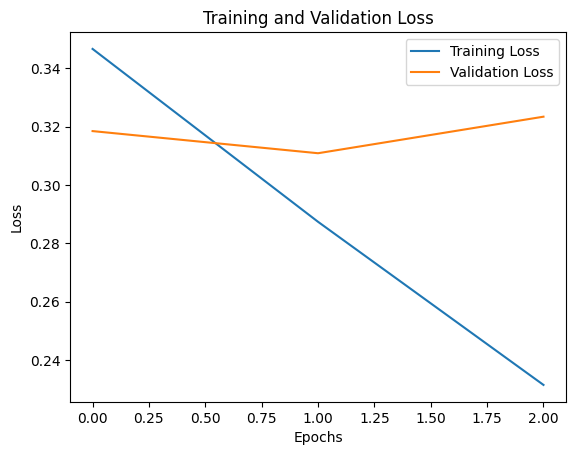

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the preprocessed CSV file
try:
    df = pd.read_csv('Finalpreprocessed_data_no_stopwords.csv')
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Initialize the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dialogues
tokenized_data = tokenizer.batch_encode_plus(
    df['Cleaned_Dialogue'].tolist(),
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Extract input IDs and attention masks from the tokenized data
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Define your emotion labels
emotions = [
    "Happiness", "Contentment", "Confidence", "Neutral", "Sadness",
    "Anger", "Fear", "Surprise", "Disgust", "Love",
    "Excitement", "Anticipation", "Nostalgia", "Confusion",
    "Frustration", "Longing", "Optimism"
]
labels = df[emotions].values

# Split the dataset into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Create datasets and dataloaders
train_dataset = EmotionDataset(train_inputs, train_masks, train_labels)
validation_dataset = EmotionDataset(validation_inputs, validation_masks, validation_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(emotions))
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = BCEWithLogitsLoss()

# Define the number of training epochs
epochs = 3

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    print(f"Starting epoch {epoch+1}/{epochs}")

    batch_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Batch")
    for step, batch in batch_progress:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask)

        loss = loss_fn(outputs.logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_progress.set_postfix({'Training Loss': '{:.3f}'.format(loss.item())})

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    print(f"Starting validation for epoch {epoch+1}/{epochs}")

    for batch in tqdm(validation_loader, desc="Validation Batch"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        loss = loss_fn(outputs.logits, b_labels)
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average validation loss: {avg_val_loss}")

# Plotting the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
try:
    model.save_pretrained('./saved_model')
    tokenizer.save_pretrained('./saved_model')
except Exception as e:
    print(f"Error saving the model: {e}")


Validation Batch: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s]


Average validation loss: 0.32342062437453784


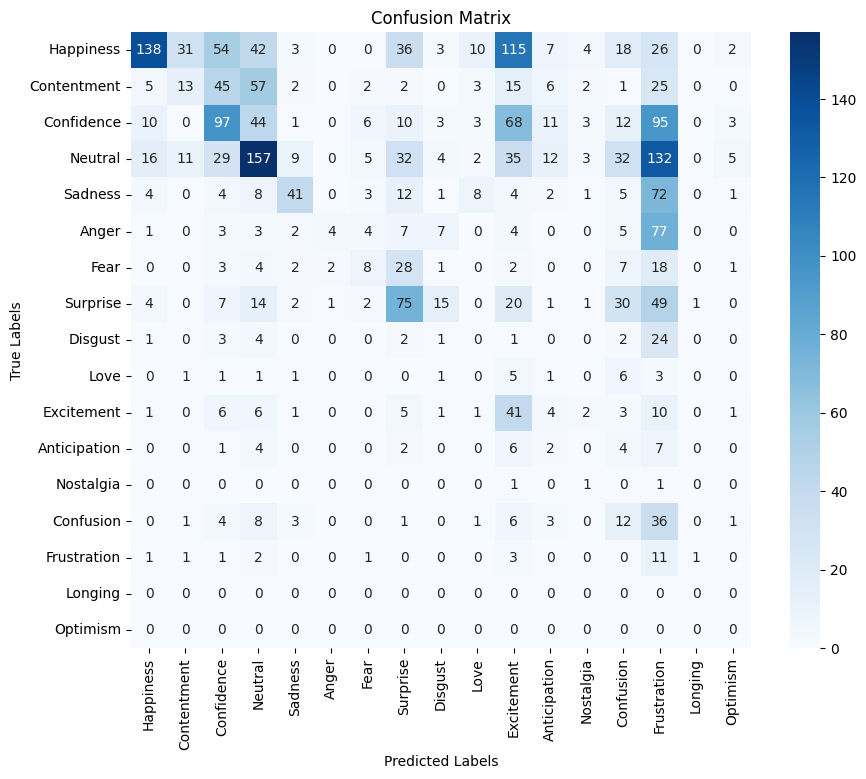

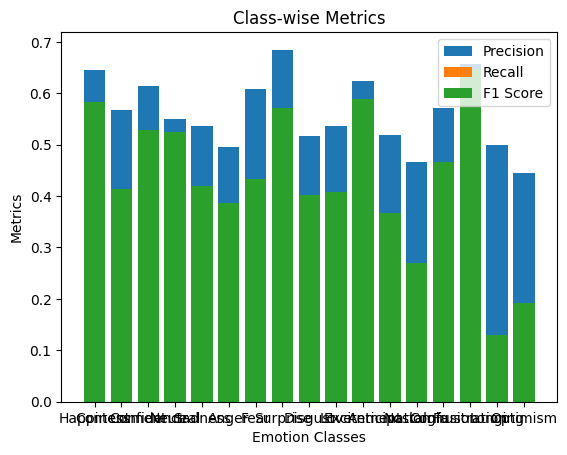

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Load the preprocessed CSV file
try:
    df = pd.read_csv('/content/drive/MyDrive/CS505/Finalpreprocessed_data_no_stopwords.csv')  # Update with your file path
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Initialize the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dialogues
tokenized_data = tokenizer.batch_encode_plus(
    df['Cleaned_Dialogue'].tolist(),
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Extract input IDs and attention masks from the tokenized data
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Define your emotion labels
emotions = [
    "Happiness", "Contentment", "Confidence", "Neutral", "Sadness",
    "Anger", "Fear", "Surprise", "Disgust", "Love",
    "Excitement", "Anticipation", "Nostalgia", "Confusion",
    "Frustration", "Longing", "Optimism"
]
labels = df[emotions].values

# Split the dataset into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Create datasets and dataloaders
train_dataset = EmotionDataset(train_inputs, train_masks, train_labels)
validation_dataset = EmotionDataset(validation_inputs, validation_masks, validation_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

# Load the saved model
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/CS505/saved_model')  # Update with your model folder path
model.eval()  # Set the model to evaluation mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize the loss function
loss_fn = BCEWithLogitsLoss()

# Validation phase
model.eval()
total_val_loss = 0
predictions = []

for batch in tqdm(validation_loader, desc="Validation Batch"):
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    loss = loss_fn(outputs.logits, b_labels)
    total_val_loss += loss.item()

    # Collect predictions
    predictions.append(outputs.logits.sigmoid().cpu().numpy())

avg_val_loss = total_val_loss / len(validation_loader)
print(f"Average validation loss: {avg_val_loss}")

# Convert predictions to numpy array
predictions = np.vstack(predictions)

# # Plotting the training and validation loss
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(validation_labels.argmax(axis=1), predictions.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Precision, Recall, F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(validation_labels, predictions.round(), average=None)
class_names = emotions
plt.bar(class_names, precision, label='Precision')
plt.bar(class_names, recall, label='Recall')
plt.bar(class_names, f1, label='F1 Score')
plt.title('Class-wise Metrics')
plt.xlabel('Emotion Classes')
plt.ylabel('Metrics')
plt.legend()
plt.show()


Confusion Matrix DataFrame:
              Happiness  Contentment  Confidence  Neutral  Sadness  Anger  \
Happiness           138           31          54       42        3      0   
Contentment           5           13          45       57        2      0   
Confidence           10            0          97       44        1      0   
Neutral              16           11          29      157        9      0   
Sadness               4            0           4        8       41      0   
Anger                 1            0           3        3        2      4   
Fear                  0            0           3        4        2      2   
Surprise              4            0           7       14        2      1   
Disgust               1            0           3        4        0      0   
Love                  0            1           1        1        1      0   
Excitement            1            0           6        6        1      0   
Anticipation          0            0           1

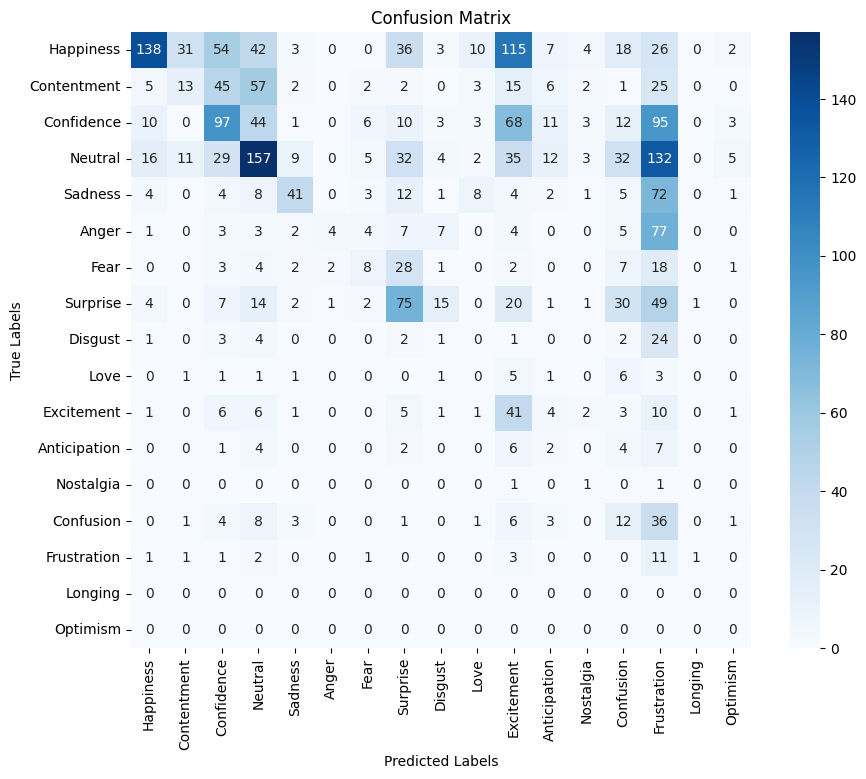

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming conf_matrix is your confusion matrix
# You can obtain it from your validation loop

# Example confusion matrix
conf_matrix = confusion_matrix(validation_labels.argmax(axis=1), predictions.argmax(axis=1))

# Convert confusion matrix to DataFrame
conf_df = pd.DataFrame(conf_matrix, index=emotions, columns=emotions)

# Display the DataFrame
print("Confusion Matrix DataFrame:")
print(conf_df)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, fmt='g', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


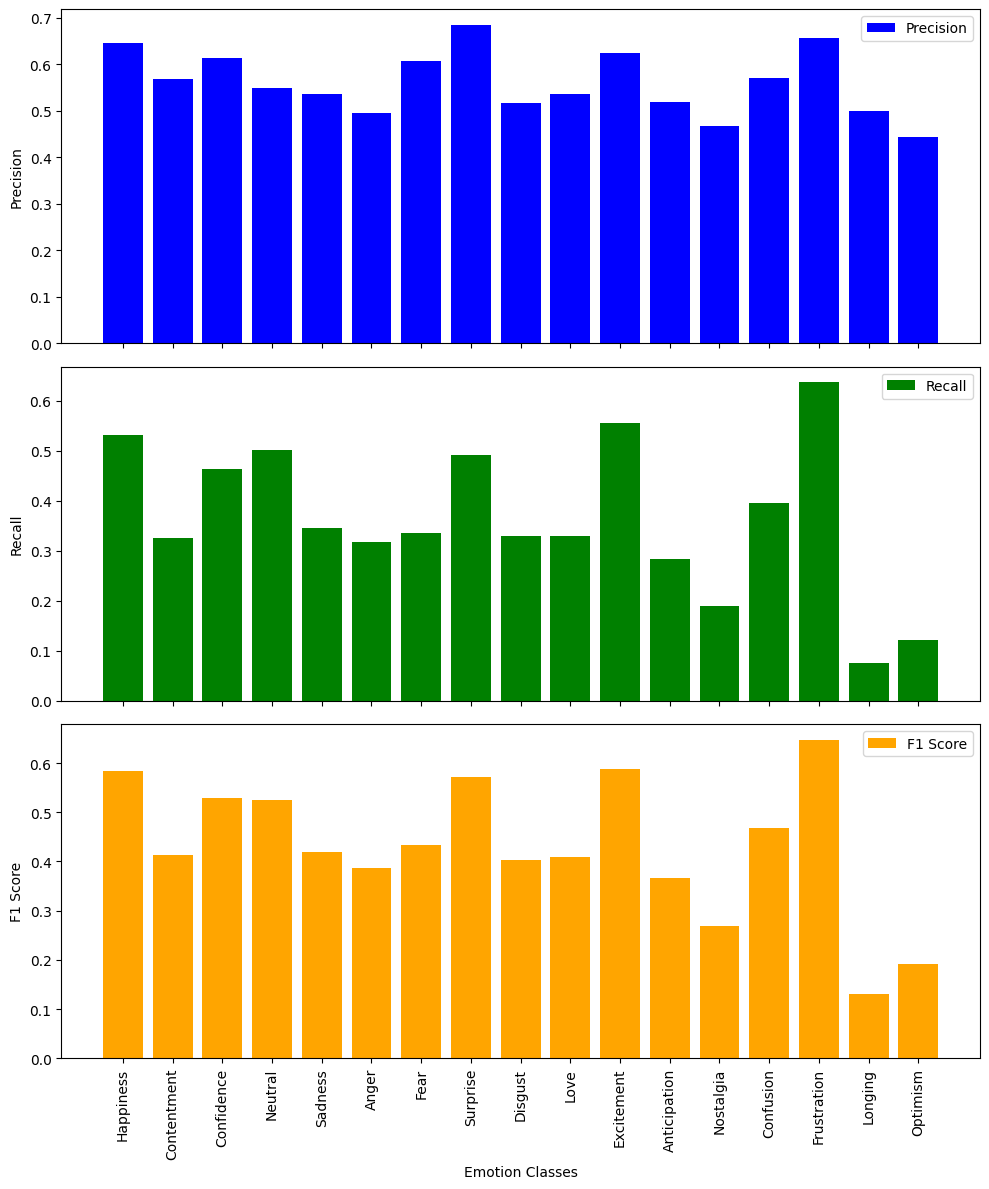

In [7]:
import numpy as np

# ... (Previous code)

# Precision, Recall, F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(validation_labels, predictions.round(), average=None)
class_names = emotions

# Create an array of x-axis positions for each class
x_positions = np.arange(len(class_names))

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Precision plot
ax1.bar(x_positions, precision, color='blue', label='Precision')
ax1.set_ylabel('Precision')
ax1.legend()

# Recall plot
ax2.bar(x_positions, recall, color='green', label='Recall')
ax2.set_ylabel('Recall')
ax2.legend()

# F1 Score plot
ax3.bar(x_positions, f1, color='orange', label='F1 Score')
ax3.set_ylabel('F1 Score')
ax3.set_xlabel('Emotion Classes')
ax3.legend()

# Set x-axis labels and rotate to a vertical orientation
plt.xticks(x_positions, class_names, rotation='vertical')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


In [9]:
import pandas as pd

# ... (Previous code)

# Precision, Recall, F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(validation_labels, predictions.round(), average=None)
class_names = emotions

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Emotion': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the DataFrame
print(metrics_df)


         Emotion  Precision    Recall  F1 Score
0      Happiness   0.645161  0.531697  0.582960
1    Contentment   0.568306  0.325000  0.413519
2     Confidence   0.613883  0.463934  0.528478
3        Neutral   0.549839  0.502203  0.524942
4        Sadness   0.535433  0.345178  0.419753
5          Anger   0.495495  0.317919  0.387324
6           Fear   0.607595  0.335664  0.432432
7       Surprise   0.684685  0.491379  0.572146
8        Disgust   0.516129  0.329897  0.402516
9           Love   0.536232  0.330357  0.408840
10    Excitement   0.624242  0.556005  0.588151
11  Anticipation   0.518519  0.283237  0.366355
12     Nostalgia   0.466667  0.189189  0.269231
13     Confusion   0.571096  0.395161  0.467112
14   Frustration   0.657303  0.636561  0.646766
15       Longing   0.500000  0.075000  0.130435
16      Optimism   0.444444  0.122137  0.191617
